In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import pmdarima as pm

In [2]:
df = pd.read_csv("../DataSets/bitcoin_technical_5Y.csv")
df

,date,open,high,low,close,volume,RSI,RS,MACD,MACD_signal,MACD_histogram,BB_Upper,BB_Mid,BB_Low
0,2018-04-25,9701.030273,9745.320313,8799.839844,8845.740234,11083100160,0.000000,0.000000,-19.109995,-10.616664,-8.493331,10476.190330,9271.620117,8067.049904
1,2018-04-26,8867.320313,9281.509766,8727.089844,9281.509766,8970559488,38.039560,0.613933,-10.836739,-10.706859,-0.129881,10126.752981,9274.916667,8423.080353
2,2018-04-27,9290.629883,9375.469727,8987.049805,8987.049805,7566289920,29.072209,0.409885,-17.439684,-12.987626,-4.452058,9955.689880,9202.949951,8450.210022
3,2018-04-28,8939.269531,9412.089844,8931.990234,9348.480469,7805479936,47.352603,0.899429,-6.278319,-10.991759,4.713440,9896.816429,9232.056055,8567.295680
4,2018-04-29,9346.410156,9531.490234,9193.709961,9419.080078,8853000192,50.351971,1.014179,3.568068,-7.045236,10.613304,9877.102724,9263.226725,8649.350727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2023-04-20,28823.683594,29076.400391,28037.257813,28245.988281,21340360360,32.300373,0.477113,688.721458,927.692397,-238.970939,31173.681929,29072.722949,26971.763970
1822,2023-04-21,28249.230469,28349.968750,27177.365234,27276.910156,20759504330,24.716457,0.328312,472.983978,836.750713,-363.766735,31249.231841,29016.016699,26782.801557
1823,2023-04-22,27265.894531,27872.142578,27169.570313,27817.500000,13125734602,34.941810,0.537085,341.692733,737.739117,-396.046384,31265.780752,28996.926270,26728.071787
1824,2023-04-23,27816.144531,27820.244141,27400.314453,27591.384766,12785446832,32.711708,0.486143,216.897604,633.570814,-416.673210,31279.719450,28986.984473,26694.249496


In [3]:
df = df[df.columns[0:5]]
del df['open']
del df['high']
del df['low']
df_origin = df.copy()
df_origin

,date,close
0,2018-04-25,8845.740234
1,2018-04-26,9281.509766
2,2018-04-27,8987.049805
3,2018-04-28,9348.480469
4,2018-04-29,9419.080078
...,...,...
1821,2023-04-20,28245.988281
1822,2023-04-21,27276.910156
1823,2023-04-22,27817.500000
1824,2023-04-23,27591.384766


In [4]:
train_origin = df[0:int(1826 * 0.7)]
test_origin = df[1278:]
test_origin['date'][1279]

'2021-10-25'

In [5]:

train_origin['date'][2]

'2018-04-27'

In [6]:
train_data = df['close'][0:int(1826 * 0.7)]
train_data

0        8845.740234
1        9281.509766
2        8987.049805
3        9348.480469
4        9419.080078
            ...     
1273    64261.992188
1274    65992.835938
1275    62210.171875
1276    60692.265625
1277    61393.617188
Name: close, Length: 1278, dtype: float64

In [7]:
test_data = df['close'][1278:]
test_data

1278    60930.835938
1279    63039.824219
1280    60363.792969
1281    58482.386719
1282    60622.136719
            ...     
1821    28245.988281
1822    27276.910156
1823    27817.500000
1824    27591.384766
1825    27430.902344
Name: close, Length: 548, dtype: float64

### Test for stationary

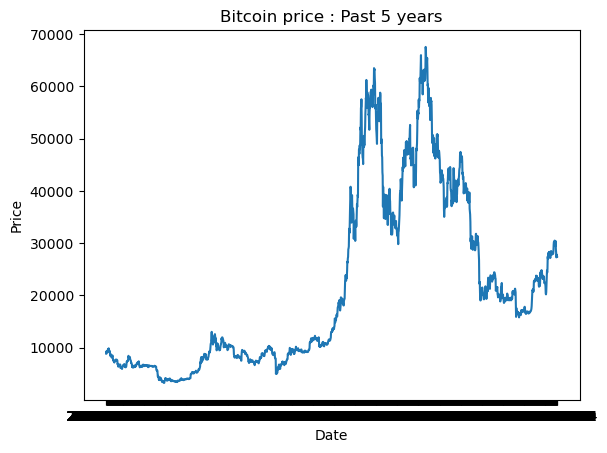

In [8]:
#Visualize data 
plt.plot(df['date'], df['close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price : Past 5 years')
plt.show()

In [9]:
##Reduce Variance using log
logged_price = np.log(df['close'])
df['close'] = np.log(df['close'])
logged_price

C:\Users\mango\AppData\Local\Temp\ipykernel_11768\568213925.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['close'] = np.log(df['close'])


0        9.087691
1        9.135780
2        9.103540
3        9.142969
4        9.150493
          ...    
1821    10.248707
1822    10.213796
1823    10.233421
1824    10.225259
1825    10.219425
Name: close, Length: 1826, dtype: float64

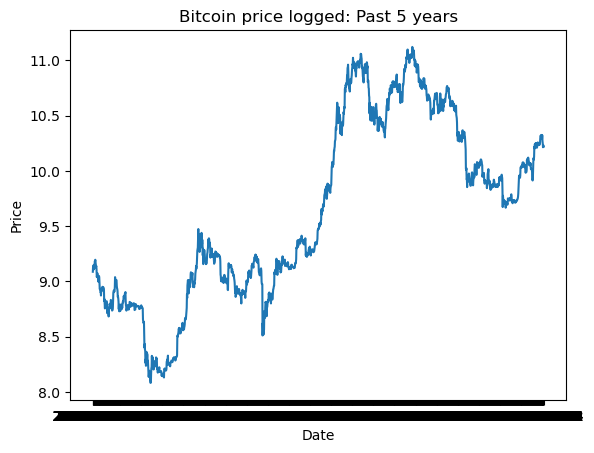

In [10]:
plt.plot(df['date'], df['close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price logged: Past 5 years')
plt.show()

### Differencing the data according to ARIMA conditions

In [11]:
def adf_test(target_series):
    """
    Parameters
    ----------
    target_series : Pandas Series
        The column of dataframe that contains the target data to which
        we want to test for stationarity e.g. Bitcoin Price.
    Returns
    -------
    adf_statistic : Float
        The adf statistic.
    p_value : Float
        The p value of the adf test.
    """
    result = adfuller(target_series)
    adf_statistic = result[0]
    p_value = result[1]
    print('ADF Statistic: %f' % adf_statistic)
    print('p-value: %f' % p_value)
    return adf_statistic, p_value

In [12]:
adf_test(df['close'])

ADF Statistic: -0.963393
p-value: 0.766381


(-0.9633926430287286, 0.7663808187094759)

In [13]:
p_value = 0.768296

In [14]:
def kpss_test(target_series):
    print("Results of KPSS Test:")
    kpsstest = kpss(target_series, regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [15]:
kpss_test(df['close'])

Results of KPSS Test:
Test Statistic            0.734965
p-value                   0.010000
Lags Used                27.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


C:\Users\mango\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [16]:
def find_order_of_differencing(df):
    """
    Parameters
    ----------
    df : DataFrame
        cleaned time series data of the respective currency.
    Returns
    -------
    d : INT
        An integar representing the number of differences to get time
        series stationary. When P value is < 0.05 from augmented
        dicky fuller test function will return d.
    """
    # get the adf statistic and p values
    adf_statistic, p_value = adf_test(df['close'])
    # get kpss statiostic and p value
    kpss_test(df['close'])
    # p value needs to be < 0.05 for time series to be stationary
    if p_value > 0.05:
        # set number of differences to 0
        d = 0
        # if p value is above threshold repeatedly run logic until below
        while p_value > 0.05:
            print("")
            print("")
            print("P value to large, trying differencing")
            # difference the time series
            df['close'] = df['close'].diff()
            # drop the null values
            df.dropna(inplace = True)
            # add 1 to d for each iteration to represent 1 differencing
            d += 1
            # perform adf test again to asses p value and exit loop if stationary
            adf_statistic, p_value = adf_test(df['close'])
            # perform KPSS test
            kpss_test(df['close'])
        print(f"Success... TS now stationary after {d} differncing")
        return df

In [17]:
df = find_order_of_differencing(df)

ADF Statistic: -0.963393
p-value: 0.766381
Results of KPSS Test:
Test Statistic            0.734965
p-value                   0.010000
Lags Used                27.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


P value to large, trying differencing
ADF Statistic: -19.988476
p-value: 0.000000
Results of KPSS Test:
Test Statistic           0.145515
p-value                  0.050898
Lags Used                9.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64
Success... TS now stationary after 1 differncing


C:\Users\mango\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\mango\AppData\Local\Temp\ipykernel_11768\911645095.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['close'] = df['close'].diff()
C:\Users\mango\AppData\Local\Temp\ipykernel_11768\911645095.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


In [18]:
df

,date,close
1,2018-04-26,0.048088
2,2018-04-27,-0.032240
3,2018-04-28,0.039429
4,2018-04-29,0.007524
5,2018-04-30,-0.019136
...,...,...
1821,2023-04-20,-0.020211
1822,2023-04-21,-0.034911
1823,2023-04-22,0.019625
1824,2023-04-23,-0.008162


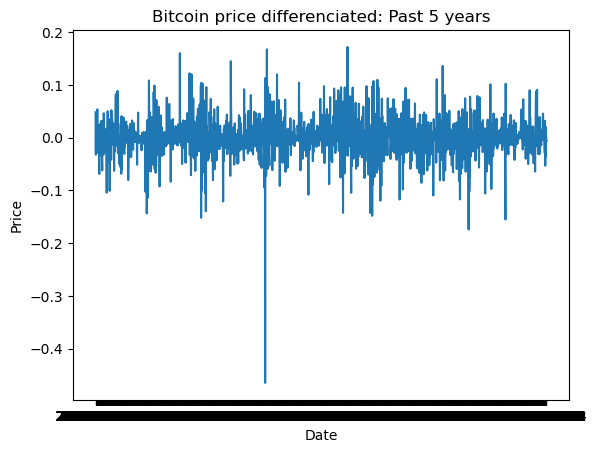

In [19]:
plt.plot(df['date'], df['close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price differenciated: Past 5 years')
plt.show()

In [20]:
def auto_arima(orig_df):
    """
    Parameters
    ----------
    orig_df : Data Frame
        Copied data frame from origonal read in prior to manual differencing.
    Returns
    -------
    model.order: Tuple
        tuple of found p,q,q values from auto arima
    differenced_by_auto_arima: Data Frame
        the differenced data frame output from the auto arima function
    fitted_residuals: The residuals of the fitted model.
    """
    #get target series
    orig_df = np.log(orig_df['close'])
    model = pm.auto_arima(orig_df,
                          start_p=10,
                          start_q=10,
                          test='adf',
                          max_p=10, 
                          max_q=10, 
                          m=1,
                          d=None,           
                          seasonal=False,   
                          D=0, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True,
                         stepwise = True)
    # difference df by d found by auto arima
    differenced_by_auto_arima = orig_df.diff(model.order[1])
    return model.order, differenced_by_auto_arima, model.resid()

In [21]:
model_order, differenced_data, model_residuals = auto_arima(df_origin)

Performing stepwise search to minimize aic
 ARIMA(10,1,10)(0,0,0)[0] intercept   : AIC=-6848.458, Time=3.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6868.135, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6870.179, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6869.836, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6869.618, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6871.819, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6869.848, Time=0.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6869.917, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6872.403, Time=1.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6869.696, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6871.520, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6870.193, Time=1.88 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6872.808, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6871.272, Time=0.07 sec
 ARIMA(1,1,0)(0,0

In [22]:
model = sm.tsa.ARIMA(np.log(train_data), order=(10,1,10))
fitted = model.fit()

C:\Users\mango\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mango\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\mango\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


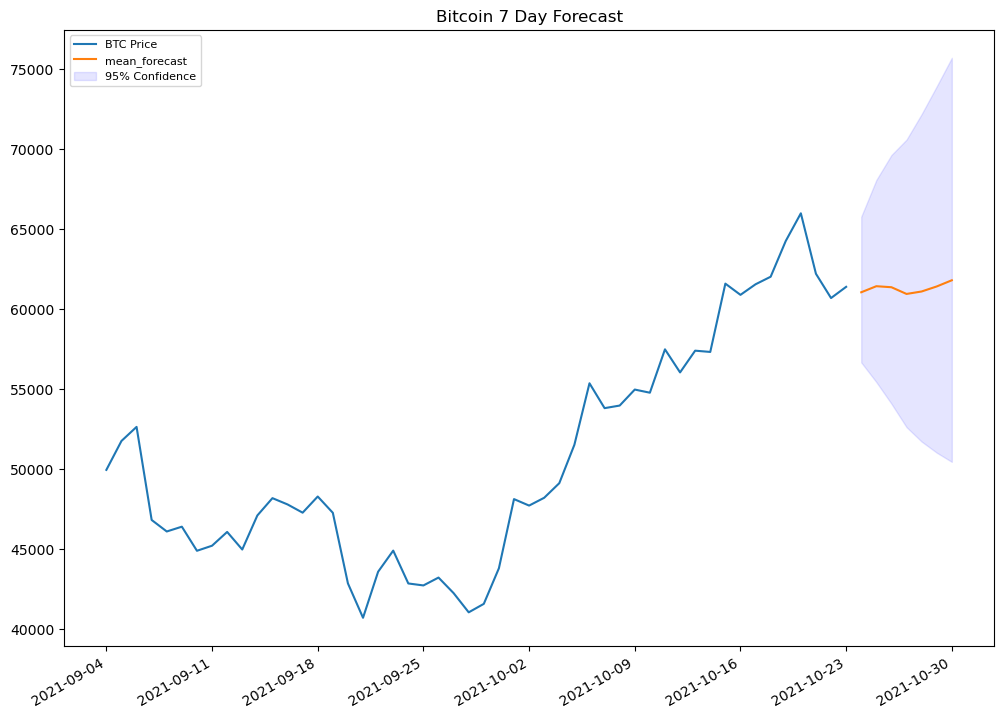

In [23]:

    fc = fitted.get_forecast(7) 
    #Set confidence to 95% 
    fc = (fc.summary_frame(alpha=0.05))
    #Get mean forecast
    fc_mean = fc['mean']
    #Get lower confidence forecast
    fc_lower = fc['mean_ci_lower']
    #Get upper confidence forecast
    fc_upper = fc['mean_ci_upper'] 
    #Set figure size
    fig, ax = plt.subplots(figsize=(12,8), dpi=100)
    #Plot last 50 price movements
    plt.plot(train_origin['date'][-50:],train_origin['close'][-50:], label='BTC Price')
    # create date axis for predictions
    future_7_days =  [str(test_origin['date'][x]) for x in range(1278,1285)]
    #Plot mean forecast
    plt.plot(future_7_days, np.exp(fc_mean), label='mean_forecast', linewidth = 1.5)
    #Create confidence interval
    plt.fill_between(future_7_days, np.exp(fc_lower),np.exp(fc_upper), color='b', alpha=.1, label = '95% Confidence')
    #Set title
    plt.title('Bitcoin 7 Day Forecast')
    #Set legend
    plt.legend(loc='upper left', fontsize=8)
    
# Set custom date tick locator and formatter
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))

# Rotate x-axis tick labels
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.show()

In [24]:
y_pred = fitted.forecast(steps=len(test_data))
y_pred

1278    11.019515
1279    11.025700
1280    11.024669
1281    11.017796
1282    11.020319
          ...    
1821    11.023604
1822    11.023604
1823    11.023604
1824    11.023604
1825    11.023604
Name: predicted_mean, Length: 548, dtype: float64

In [25]:
mae = mean_absolute_error(test_data, y_pred)
mse = mean_squared_error(test_data, y_pred)
r2 = r2_score(test_data, y_pred)

print("Mean Absolute error:", mae)
print("Mean Squared error:", mse)
print("R-squared:", r2)

Mean Absolute error: 30787.066800915345
Mean Squared error: 1116075811.3691332
R-squared: -5.634133945745225
